In [58]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

DATA_CSV  = "data/RDU.csv"   
TIME_COL  = "valid"
TARGET_COL = "tmpf"

# Assignment window 
FORECAST_START = pd.Timestamp("2025-09-17 00:00:00")
FORECAST_END   = pd.Timestamp("2025-09-30 23:00:00")

np.random.seed(42)


Utilities

In [59]:
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def to_numeric_cols(df, cols):
    df = df.copy()
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").replace([np.inf, -np.inf], np.nan)
    return df



Load, coerce, build hourly actuals

In [ ]:
# Load everything as object
raw = pd.read_csv(DATA_CSV, low_memory=False)

# ensure timestamp present
raw[TIME_COL] = pd.to_datetime(raw[TIME_COL], errors="coerce")
raw = raw.dropna(subset=[TIME_COL]).sort_values(TIME_COL)

# We only need 'tmpf' for training after removing exogenous variables
raw["tmpf"] = pd.to_numeric(raw["tmpf"], errors="coerce")

# Minute-level -> hourly by mean
hourly = (
    raw.set_index(TIME_COL)[["tmpf"]]
        .resample("H").mean()
)

# Reindex to full hourly timeline up to FORECAST_END
lo = hourly.index.min().floor("H")
hi = FORECAST_END.floor("H")
full_idx = pd.date_range(lo, hi, freq="H")
full = hourly.reindex(full_idx)
full.index.name = TIME_COL

# keep a copy of hourly actual target
full_target = full[TARGET_COL].copy()

print("Columns available after hourly mean:", list(full.columns))
print("Sample around forecast start:")
print(full.loc[FORECAST_START:FORECAST_START + pd.Timedelta('4H')])


Columns available after hourly mean: ['tmpf']
Sample around forecast start:
                     tmpf
valid                    
2025-09-17 00:00:00  63.0
2025-09-17 01:00:00  62.0
2025-09-17 02:00:00  62.0
2025-09-17 03:00:00  62.0
2025-09-17 04:00:00  61.0


C:\Users\tiffa\AppData\Local\Temp\ipykernel_27568\1886193630.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("H").mean()
C:\Users\tiffa\AppData\Local\Temp\ipykernel_27568\1886193630.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  lo = hourly.index.min().floor("H")
C:\Users\tiffa\AppData\Local\Temp\ipykernel_27568\1886193630.py:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hi = FORECAST_END.floor("H")
C:\Users\tiffa\AppData\Local\Temp\ipykernel_27568\1886193630.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(lo, hi, freq="H")
C:\Users\tiffa\AppData\Local\Temp\ipykernel_27568\1886193630.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  print(full.loc[FORECAST_

target based features

In [ ]:
def build_exog_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Builds only non-leaking time features from the DataFrame index.
    All weather-related exogenous features have been removed to eliminate
    the future-data leakage risk associated with them.
    """
    f = pd.DataFrame(index=df.index)

    #Simple time features
    # These features are non-leaking as they are derived only from the timestamp.
    idx = df.index
    f["hour"] = idx.hour         # 0–23
    f["doy"]  = idx.dayofyear     # 1–366 (Day of Year)
    f["dow"]  = idx.dayofweek     # 0=Mon..6=Sun (Day of Week)

    return f
exog_feat = build_exog_features(full)

Target Based Features

In [65]:
def build_target_features_for_training(y: pd.Series) -> pd.DataFrame:
    f = pd.DataFrame(index=y.index)
    for L in [1, 24, 48, 72]:
        f[f"{TARGET_COL}_lag{L}"] = y.shift(L)
    f["roll_mean_24"]  = y.rolling(24, min_periods=1).mean().shift(1)
    f["roll_std_24"]   = y.rolling(24, min_periods=1).std().shift(1)
    f["roll_mean_168"] = y.rolling(168, min_periods=1).mean().shift(1)
    return f

target_train_feat = build_target_features_for_training(full_target)

# Combine full feature frame (for TRAIN building only)
feat_full_for_train = exog_feat.join(target_train_feat)
feat_full_for_train[TARGET_COL] = full_target

# Train/Test split indices
train_end = FORECAST_START - pd.Timedelta(hours=1)
train_idx = feat_full_for_train.index <= train_end
test_idx  = (feat_full_for_train.index >= FORECAST_START) & (feat_full_for_train.index <= FORECAST_END)

X_train = feat_full_for_train.loc[train_idx].drop(columns=[TARGET_COL])
y_train = feat_full_for_train.loc[train_idx, TARGET_COL]

# ensure no NaNs in training rows
train_mask = X_train.dropna().index.intersection(y_train.dropna().index)
X_train = X_train.loc[train_mask]
y_train = y_train.loc[train_mask]

print(f"Usable train rows: {len(train_mask)}")


Usable train rows: 642301


Fit models (Linear Regression + Random Forest)
added scaler because linear performed very poorly

In [66]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

linreg = make_pipeline(StandardScaler(), LinearRegression())

rf = RandomForestRegressor(
    n_estimators=600,
    max_depth=22,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

linreg.fit(X_train, y_train)
rf.fit(X_train, y_train)

print("Models trained.")


Models trained.


Walk-forward forecasting on the test window (strict, no look-ahead)

In [67]:
# pre-list of feature columns to fetch from exog_feat at time t
EXOG_COLS = list(exog_feat.columns)

def target_features_from_history(history: pd.Series):
    """Build target-based features at current t from history up to t-1."""
    f = {}
    for L in [1,24,48,72]:
        f[f"{TARGET_COL}_lag{L}"] = history.iloc[-L] if len(history) >= L else np.nan
    # rolling over history
    f["roll_mean_24"]  = history.rolling(24, min_periods=1).mean().iloc[-1] if len(history) else np.nan
    f["roll_std_24"]   = history.rolling(24, min_periods=1).std().iloc[-1]  if len(history) else np.nan
    f["roll_mean_168"] = history.rolling(168, min_periods=1).mean().iloc[-1] if len(history) else np.nan
    return pd.Series(f)

# initialize history with actuals up to train_end
history = full_target.loc[:train_end].copy()

pred_lr, pred_rf, actuals = [], [], []

for ts in full.loc[test_idx].index:
    # exogenous (already shifted/rolled safely)
    x_exog = exog_feat.loc[ts, EXOG_COLS]

    # target-based features from history (uses up to t-1)
    x_tgt = target_features_from_history(history)

    # combine
    row = pd.concat([x_exog, x_tgt])

    # fill gaps so we can always predict at start of test
    xrow = row.fillna(method="ffill").fillna(0).values.reshape(1, -1)

    # make predictions
    yhat_lr = linreg.predict(xrow)[0]
    yhat_rf = rf.predict(xrow)[0]

    pred_lr.append(yhat_lr)
    pred_rf.append(yhat_rf)

    # append RF prediction to history for recursive lags
    history = pd.concat([history, pd.Series({ts: yhat_rf})])

    # store actual (may be NaN if no ground truth at that hour)
    actuals.append(full_target.loc[ts])

df_results = pd.DataFrame({
    "timestamp": full.loc[test_idx].index,
    "actual_tmpf": actuals,
    "pred_lr": pred_lr,
    "pred_rf": pred_rf,
}).set_index("timestamp")

df_results.head()


C:\Users\tiffa\AppData\Local\Temp\ipykernel_27568\1396888553.py:31: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  xrow = row.fillna(method="ffill").fillna(0).values.reshape(1, -1)
c:\Users\tiffa\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\tiffa\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\tiffa\AppData\Local\Temp\ipykernel_27568\1396888553.py:31: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  xrow = row.fillna(method="ffill").fillna(0).values.reshape(1, -1)
c:\Users\

,actual_tmpf,pred_lr,pred_rf
timestamp,,,
2025-09-17 00:00:00,63.0,63.980667,62.723448
2025-09-17 01:00:00,62.0,63.504676,62.716433
2025-09-17 02:00:00,62.0,63.363248,62.712731
2025-09-17 03:00:00,62.0,63.241707,62.716043
2025-09-17 04:00:00,61.0,63.116373,62.750833


Metrics (masked to actual availability) + plots

== Test metrics (masked to hours with actuals) ==
Linear Regression: MAE=5.818, RMSE=7.349, MSE=54.009
Random Forest:     MAE=5.665, RMSE=7.060,  MSE=49.845


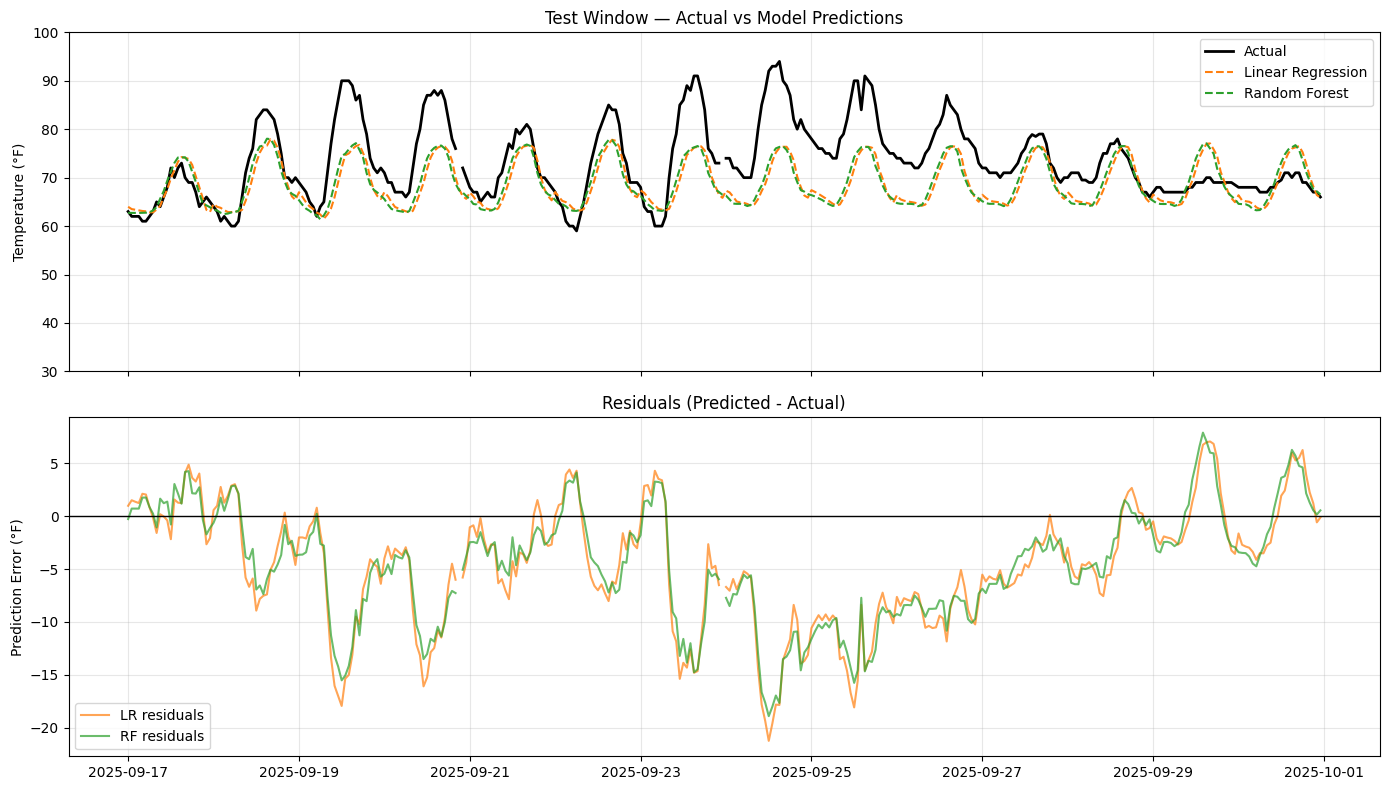

In [68]:
mask = df_results["actual_tmpf"].notna()

mae_lr  = mean_absolute_error(df_results.loc[mask,"actual_tmpf"], df_results.loc[mask,"pred_lr"])
rmse_lr = rmse(df_results.loc[mask,"actual_tmpf"], df_results.loc[mask,"pred_lr"])
mse_lr = mean_squared_error(df_results.loc[mask,"actual_tmpf"], df_results.loc[mask,"pred_lr"])

mae_rf  = mean_absolute_error(df_results.loc[mask,"actual_tmpf"], df_results.loc[mask,"pred_rf"])
rmse_rf = rmse(df_results.loc[mask,"actual_tmpf"], df_results.loc[mask,"pred_rf"])
mse_rf = mean_squared_error(df_results.loc[mask,"actual_tmpf"], df_results.loc[mask,"pred_rf"])


print("== Test metrics (masked to hours with actuals) ==")
print(f"Linear Regression: MAE={mae_lr:.3f}, RMSE={rmse_lr:.3f}, MSE={mse_lr:.3f}")
print(f"Random Forest:     MAE={mae_rf:.3f}, RMSE={rmse_rf:.3f},  MSE={mse_rf:.3f}")

fig, axes = plt.subplots(2, 1, figsize=(14,8), sharex=True)

# 1. Actual vs Predictions
axes[0].plot(df_results.index, df_results["actual_tmpf"], label="Actual", color="black", linewidth=2)
axes[0].plot(df_results.index, df_results["pred_lr"], label="Linear Regression", linestyle="--", color="tab:orange")
axes[0].plot(df_results.index, df_results["pred_rf"], label="Random Forest", linestyle="--", color="tab:green")

axes[0].set_ylabel("Temperature (°F)")
axes[0].set_title("Test Window — Actual vs Model Predictions")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Clip the y-axis to focus on realistic temps
axes[0].set_ylim(30, 100)

# 2. Residuals (error = pred - actual)
axes[1].plot(df_results.index, df_results["pred_lr"] - df_results["actual_tmpf"], 
             label="LR residuals", color="tab:orange", alpha=0.7)
axes[1].plot(df_results.index, df_results["pred_rf"] - df_results["actual_tmpf"], 
             label="RF residuals", color="tab:green", alpha=0.7)

axes[1].axhline(0, color="black", linewidth=1)
axes[1].set_ylabel("Prediction Error (°F)")
axes[1].set_title("Residuals (Predicted - Actual)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Hour-of-day error breakdown (optional but insightful)

In [69]:
tmp = df_results.loc[mask].copy()
tmp["hour"] = tmp.index.hour

by_hour = tmp.groupby("hour").apply(
    lambda g: pd.Series({
        "MAE_LR": mean_absolute_error(g["actual_tmpf"], g["pred_lr"]),
        "MAE_RF": mean_absolute_error(g["actual_tmpf"], g["pred_rf"]),
    })
)
by_hour


C:\Users\tiffa\AppData\Local\Temp\ipykernel_27568\2667335598.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  by_hour = tmp.groupby("hour").apply(


,MAE_LR,MAE_RF
hour,,
0,3.203590,4.357581
1,3.813433,4.458487
2,4.028282,4.407447
3,3.859698,4.128653
4,4.155727,4.370544
5,4.162000,4.312018
6,4.106871,4.394938
7,4.085304,3.932121
8,6.204648,5.046201


RF feature importances (for your slide)

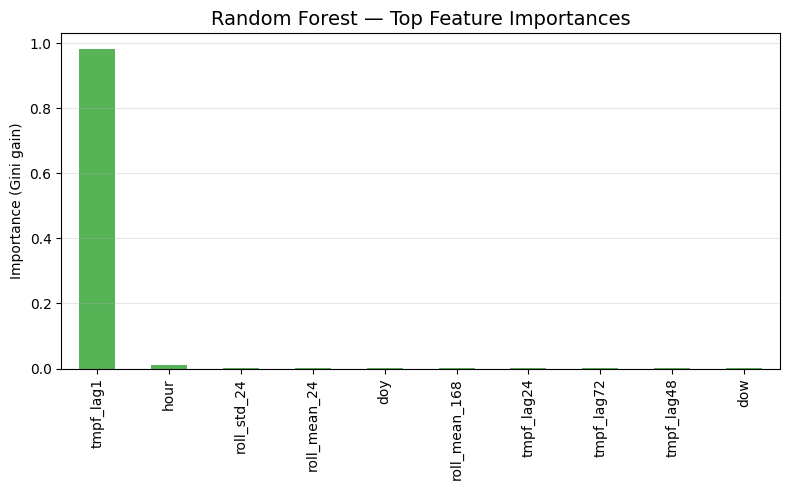

Top 12 most important features:

tmpf_lag1        0.981777
hour             0.009856
roll_std_24      0.001765
roll_mean_24     0.001515
doy              0.001236
roll_mean_168    0.001015
tmpf_lag24       0.000935
tmpf_lag72       0.000756
tmpf_lag48       0.000738
dow              0.000407
dtype: float64


In [ ]:
# Make sure FEATURES matches what you actually trained on
FEATURES = X_train.columns.tolist()

# Build feature importance series
fi = pd.Series(rf.feature_importances_, index=FEATURES).sort_values(ascending=False)

# Plot top-12
plt.figure(figsize=(8,5))
fi.head(12).plot(kind="bar", color="tab:green", alpha=0.8)
plt.title("Random Forest — Top Feature Importances", fontsize=14)
plt.ylabel("Importance (Gini gain)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Display top features as a table as well
print("Top 10 most important features:\n")
print(fi.head(12))
